# Heavylight + Heavytables Examples: Vectorised

In [1]:
import heavylight
import heavytables
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
mort = heavytables.Table.read_csv('csv_tables/fake_tmnl16_bound.csv')
mort.df

,age|int,dur|int_bound,q_x|float
0,18,0,0.000005
6,19,0,0.000006
12,20,0,0.000006
18,21,0,0.000007
24,22,0,0.000008
...,...,...,...
581,114,5,0.201897
587,115,5,0.223130
593,116,5,0.246597
599,117,5,0.272532


In [95]:
class ExampleModel(heavylight.Model):
    def t(self, t):
        return t
    
    def num_active(self, t):
        if t == 0:
            return self.data['initial_pols_if']
        else:
            return self.num_active(t - 1) - self.num_deaths(t - 1) # - self.num_lapses(t - 1)

    def num_deaths(self, t):
        return self.num_active(t) * self.q_x_m(t)
    
    def q_x_m(self, t):
        """Monthly mortality rate"""
        return 1 - (1 - self.q_x(t))**(1/12)
    
    def q_x(self, t):
        """annual mortality rate"""
        return mort[self.age(t), self.dur(t)] #TODO: pass this in as the basis rather than using global.
    
    def age(self, t):
        if t == 0:
            return self.data['init_age']
        elif t % 12 == 0:
            return self.age(t - 1) + 1
        else:
            return self.age(t - 1)
        
    def dur(self, t):
        """duration in force at time t"""
        return t  # assume all policies start at t=0, i.e. new business rather than existing business.
    
    def forward_rate(self):
        """monthly forward rate, for laziness flat but should use a curve"""
        return (1 + 0.04)**(1/12) - 1
    
    def disc_factor(self, t):
        if t == 0:
            return 1.0
        else:
            return self.disc_factor(t - 1) / (1 + self.forward_rate())
        
    def expected_claims(self, t):
        return self.data['sum_assured'] * self.num_deaths(t)
    
    def pv_claim(self, t):
        """present value of the claim occuring at time t"""
        return self.expected_claims(t) * self.disc_factor(t)
        


In [123]:
# define our data
rng = np.random.default_rng(seed=42)
policies = 100_000
data = dict(
    init_age = rng.integers(low=20, high=75, size=policies),
    initial_pols_if = np.ones(policies),
    sum_assured = 100_000.0 * np.ones(policies),
)
pd.DataFrame(data)

,init_age,initial_pols_if,sum_assured
0,24,1.0,100000.0
1,62,1.0,100000.0
2,56,1.0,100000.0
3,44,1.0,100000.0
4,43,1.0,100000.0
...,...,...,...
99995,74,1.0,100000.0
99996,20,1.0,100000.0
99997,51,1.0,100000.0
99998,20,1.0,100000.0


In [110]:
proj = ExampleModel(do_run=True, proj_len=241, data=data)
proj.ToDataFrame()

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",1.000000,0,"[0.07638365422391047, 3.415099720149861, 1.874...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[7.638365422391047e-07, 3.415099720149861e-05,...","[0.07638365422391047, 3.415099720149861, 1.874...","[9.166e-06, 0.000409735, 0.000224867, 6.7729e-...","[7.638365422391047e-07, 3.415099720149861e-05,..."
1,1,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.996737,1,"[0.09329207409341334, 4.171239433565282, 2.289...","[0.9999992361634578, 0.9999658490027985, 0.999...","[9.329207409341333e-07, 4.171239433565282e-05,...","[0.09298765670241319, 4.157628439941843, 2.281...","[1.1195e-05, 0.000500451, 0.000274654, 8.2724e...","[9.329214535336305e-07, 4.171381890416548e-05,..."
2,2,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.993485,2,"[0.11395052081783044, 5.094816078104423, 2.795...","[0.9999983032427169, 0.9999241366084628, 0.999...","[1.1395052081783044e-06, 5.094816078104423e-05...","[0.1132080799348082, 5.061620970958657, 2.7776...","[1.3674e-05, 0.000611253, 0.000335463, 0.00010...","[1.1395071416453462e-06, 5.095202617455552e-05..."
3,3,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.990243,3,"[0.13918400404284598, 6.222890704140872, 3.414...","[0.9999971637375087, 0.9998731884476818, 0.999...","[1.39184004042846e-06, 6.222890704140873e-05, ...","[0.13782594893499206, 6.162172315095435, 3.381...","[1.6702e-05, 0.000746586, 0.000409735, 0.00012...","[1.391843988063357e-06, 6.223679938655025e-05,..."
4,4,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.987012,4,"[0.1700008707325929, 7.60075737384157, 4.17094...","[0.9999957718974682, 0.9998109595406404, 0.999...","[1.700008707325929e-06, 7.60075737384157e-05, ...","[0.16779281729172582, 7.502035064948777, 4.116...","[2.04e-05, 0.000911882, 0.000500451, 0.0001507...","[1.7000158951674393e-06, 7.602194496181269e-05..."
...,...,...,...,...,...,...,...,...,...,...
236,236,"[43, 81, 75, 63, 62, 86, 43, 77, 50, 44, 67, 9...",0.462393,236,"[1.3863059086713565, 58.341945166106015, 32.92...","[0.998547338944663, 0.9369541070491794, 0.9649...","[1.3863059086713565e-05, 0.0005834194516610602...","[0.6410177686304601, 26.97689108443648, 15.223...","[0.000166586, 0.007446583, 0.004086771, 0.0012...","[1.3883226709476837e-05, 0.0006226766575563314..."
237,237,"[43, 81, 75, 63, 62, 86, 43, 77, 50, 44, 67, 9...",0.460884,237,"[1.386286662272138, 58.305616998694646, 32.912...","[0.9985334758855763, 0.9363706875975183, 0.964...","[1.3862866622721378e-05, 0.0005830561699869465...","[0.6389172205131276, 26.87212087293099, 15.168...","[0.000166586, 0.007446583, 0.004086771, 0.0012...","[1.3883226709476837e-05, 0.0006226766575563314..."
238,238,"[43, 81, 75, 63, 62, 86, 43, 77, 50, 44, 67, 9...",0.459380,238,"[1.3862674161401212, 58.26931145198514, 32.901...","[0.9985196130189535, 0.9357876314275313, 0.964...","[1.386267416140121e-05, 0.0005826931145198514,...","[0.6368235556720616, 26.767757557727396, 15.11...","[0.000166586, 0.007446583, 0.004086771, 0.0012...","[1.3883226709476837e-05, 0.0006226766575563314..."
239,239,"[43, 81, 75, 63, 62, 86, 43, 77, 50, 44, 67, 9...",0.457881,239,"[1.386248170275303, 58.2330285118921, 32.88994...","[0.9985057503447922, 0.9352049383130114, 0.963...","[1.3862481702753029e-05, 0.000582330285118921,...","[0.6347367515514865, 26.663799558561625, 15.05...","[0.000166586, 0.007446583, 0.004086771, 0.0012...","[1.3883226709476837e-05, 0.0006226766575563314..."


<Axes: >

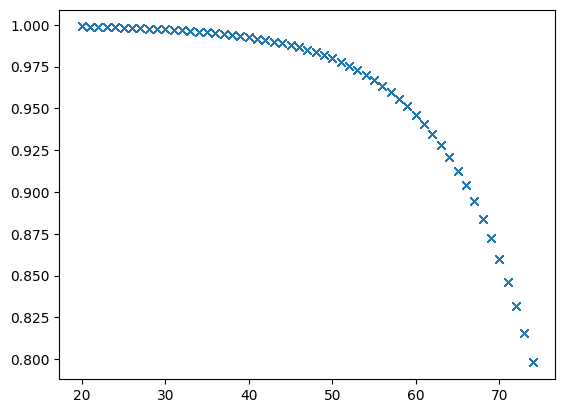

In [111]:
sns.scatterplot(x=proj.age(0), y=proj.num_active(240), marker='x')

<Axes: ylabel='Density'>

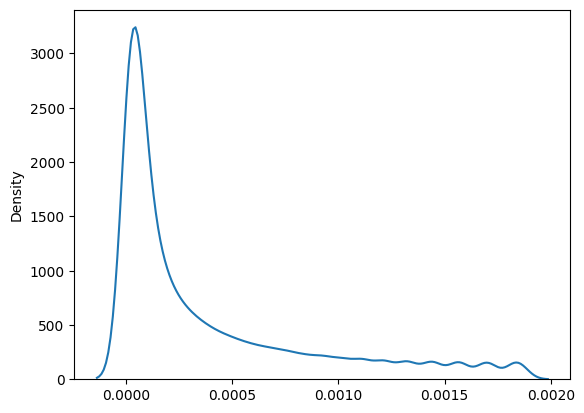

In [122]:
sns.kdeplot(x=proj.num_deaths(240))

In [113]:
df = proj.ToDataFrame()
df.head(3)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",1.000000,0,"[0.07638365422391047, 3.415099720149861, 1.874...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[7.638365422391047e-07, 3.415099720149861e-05,...","[0.07638365422391047, 3.415099720149861, 1.874...","[9.166e-06, 0.000409735, 0.000224867, 6.7729e-...","[7.638365422391047e-07, 3.415099720149861e-05,..."
1,1,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.996737,1,"[0.09329207409341334, 4.171239433565282, 2.289...","[0.9999992361634578, 0.9999658490027985, 0.999...","[9.329207409341333e-07, 4.171239433565282e-05,...","[0.09298765670241319, 4.157628439941843, 2.281...","[1.1195e-05, 0.000500451, 0.000274654, 8.2724e...","[9.329214535336305e-07, 4.171381890416548e-05,..."
2,2,"[24, 62, 56, 44, 43, 67, 24, 58, 31, 25, 48, 7...",0.993485,2,"[0.11395052081783044, 5.094816078104423, 2.795...","[0.9999983032427169, 0.9999241366084628, 0.999...","[1.1395052081783044e-06, 5.094816078104423e-05...","[0.1132080799348082, 5.061620970958657, 2.7776...","[1.3674e-05, 0.000611253, 0.000335463, 0.00010...","[1.1395071416453462e-06, 5.095202617455552e-05..."


In [114]:
df['num_active'].map(lambda x: x[9999])

0      1.000000
1      0.999986
2      0.999969
3      0.999948
4      0.999923
         ...   
236    0.973904
237    0.973658
238    0.973412
239    0.973166
240    0.972921
Name: num_active, Length: 241, dtype: float64

In [115]:
def get_policy_df(model_inst, index):
    """Pull out results for one policy"""
    full_df = model_inst.ToDataFrame()
    for col in full_df:
        if isinstance(full_df[col].iloc[0],np.ndarray):
            full_df[col] = full_df[col].map(lambda x: x[index])
    return full_df

In [116]:
# grab the index for the oldest policy
data['init_age'].argmax()

140

In [117]:
# view the policy data for this
get_policy_df(proj, 140)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,74,1.000000,0,11.343474,1.000000,0.000113,11.343474,0.001360,0.000113
1,1,74,0.996737,1,13.855292,0.999887,0.000139,13.810082,0.001662,0.000139
2,2,74,0.993485,2,16.923411,0.999748,0.000169,16.813147,0.002029,0.000169
3,3,74,0.990243,3,20.671061,0.999579,0.000207,20.469368,0.002479,0.000207
4,4,74,0.987012,4,25.248838,0.999372,0.000252,24.920894,0.003028,0.000253
...,...,...,...,...,...,...,...,...,...,...
236,236,93,0.462393,236,167.696728,0.804681,0.001677,77.541747,0.024724,0.002084
237,237,93,0.460884,237,167.347246,0.803004,0.001673,77.127653,0.024724,0.002084
238,238,93,0.459380,238,166.998491,0.801330,0.001670,76.715771,0.024724,0.002084
239,239,93,0.457881,239,166.650464,0.799660,0.001667,76.306087,0.024724,0.002084


In [118]:
def sum_proj(proj):
    """Sum up results across the dataframe, note that some variables will not be sensible"""
    full_df = proj.ToDataFrame()
    for col in full_df:
        if isinstance(full_df[col].iloc[0],np.ndarray):
            full_df[col] = full_df[col].apply(np.sum)
    return full_df

sum_proj(proj)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,4699303,1.000000,0,2.155282e+05,100000.000000,2.155282,2.155282e+05,25.854880,2.155282
1,1,4699303,0.996737,1,2.632501e+05,99997.844718,2.632501,2.623911e+05,31.579222,2.632659
2,2,4699303,0.993485,2,3.215396e+05,99995.212217,3.215396,3.194446e+05,38.570949,3.215823
3,3,4699303,0.990243,3,3.927370e+05,99991.996822,3.927370,3.889049e+05,47.110665,3.928241
4,4,4699303,0.987012,4,4.797014e+05,99988.069452,4.797014,4.734709e+05,57.541097,4.798602
...,...,...,...,...,...,...,...,...,...,...
236,236,6599303,0.462393,236,3.520841e+06,96108.009239,35.208415,1.628011e+06,469.890370,39.393959
237,237,6599303,0.460884,237,3.517126e+06,96072.800825,35.171264,1.620987e+06,469.890370,39.393959
238,238,6599303,0.459380,238,3.513417e+06,96037.629561,35.134166,1.613993e+06,469.890370,39.393959
239,239,6599303,0.457881,239,3.509712e+06,96002.495395,35.097121,1.607031e+06,469.890370,39.393959


In [119]:
# using sum will sum each policy separately (over all t) - most useful for calculating present values
proj.pv_claim.sum()

array([92.848227, 4039.034205, 2244.605027, ..., 1369.633105, 62.250880,
       9543.561065])

In [120]:
proj.disc_factor(12) * 1.04 # check discount factor works, i.e. 12 months compound is 1/1.04

0.9999999999999993